In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import warnings
warnings.filterwarnings("ignore", message='.*UserWarning.*')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

In [2]:
# load data obtained from each operating conditions at current density of 600 mA/cm^2
as_600 = np.load("Data/wrangled_data/as_600.npy")
cs_600 = np.load("Data/wrangled_data/cs_600.npy")
normal_600 = np.load("Data/wrangled_data/normal_600.npy")

In [3]:
# Create labels for each SoH
label_AS = np.zeros(as_600.shape[0])
label_normal = np.ones(normal_600.shape[0])
label_CS = np.ones(cs_600.shape[0]) * 2

In [4]:
X = np.vstack((as_600, normal_600, cs_600))
Y = np.hstack((label_AS, label_normal, label_CS))

In [5]:
train_split = 0.80

In [6]:
# chronological split

X_time_train = np.vstack((np.vstack((as_600[0:round(as_600.shape[0] * train_split), :],
                                   normal_600[0:round(normal_600.shape[0] * train_split), :])),
                        cs_600[0:round(cs_600.shape[0] * train_split), :]))
y_time_train = np.hstack((np.hstack((label_AS[0:round(label_AS.shape[0] * train_split)],
                                    label_normal[0:round(label_normal.shape[0] * train_split)])),
                         label_CS[0:round(label_CS.shape[0] * train_split)]))
X_time_test = np.vstack((np.vstack((as_600[round(as_600.shape[0] * train_split):, :],
                                  normal_600[round(normal_600.shape[0] * train_split):, :])),
                       cs_600[round(cs_600.shape[0] * train_split):, :]))
y_time_test = np.hstack((np.hstack((label_AS[round(as_600.shape[0] * train_split):],
                                   label_normal[round(normal_600.shape[0] * train_split):])),
                        label_CS[round(cs_600.shape[0] * train_split):]))

In [7]:
X_time_train.shape, X_time_test.shape

((520, 10001), (130, 10001))

In [8]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, accuracy_score, multilabel_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit


In [18]:
def confusion_matrix_plot(conf_mat: np.ndarray, model_name: str, split_type: int) -> plt.Figure:
    ax = plt.axes()
    sns.heatmap(np.array(conf_mat), annot=True, cmap="BuGn", fmt="g")

    
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    plt.show()   


In [10]:
rfc_param_grid = {'max_depth': [ 5, 25, 50, 75, 100], 
                  'n_estimators': [5, 25, 50, 75, 100]}
rfc = RandomForestClassifier(random_state=1234, )
tscv = TimeSeriesSplit(n_splits=5)
rfc_grid_search = GridSearchCV(estimator=rfc, param_grid=rfc_param_grid, cv=tscv, verbose=3)
rfc_grid_search.fit(X_time_train, y_time_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END .......max_depth=5, n_estimators=5;, score=0.814 total time=   0.1s
[CV 2/5] END .......max_depth=5, n_estimators=5;, score=0.616 total time=   0.2s
[CV 3/5] END .......max_depth=5, n_estimators=5;, score=0.919 total time=   0.5s
[CV 4/5] END .......max_depth=5, n_estimators=5;, score=0.128 total time=   0.6s
[CV 5/5] END .......max_depth=5, n_estimators=5;, score=0.721 total time=   0.6s
[CV 1/5] END ......max_depth=5, n_estimators=25;, score=0.814 total time=   0.3s
[CV 2/5] END ......max_depth=5, n_estimators=25;, score=0.663 total time=   0.6s
[CV 3/5] END ......max_depth=5, n_estimators=25;, score=0.942 total time=   1.2s
[CV 4/5] END ......max_depth=5, n_estimators=25;, score=0.128 total time=   1.7s
[CV 5/5] END ......max_depth=5, n_estimators=25;, score=0.756 total time=   2.3s
[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.814 total time=   0.9s
[CV 2/5] END ......max_depth=5, n_estimators=50

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestClassifier(random_state=1234),
             param_grid={'max_depth': [5, 25, 50, 75, 100],
                         'n_estimators': [5, 25, 50, 75, 100]},
             verbose=3)

In [12]:
rfc_grid_search.best_params_

{'max_depth': 25, 'n_estimators': 75}

In [13]:
rfc_grid_search.best_estimator_

RandomForestClassifier(max_depth=25, n_estimators=75, random_state=1234)

[[33  0  7]
 [ 1 49  0]
 [ 5  0 35]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84        40
         1.0       1.00      0.98      0.99        50
         2.0       0.83      0.88      0.85        40

    accuracy                           0.90       130
   macro avg       0.89      0.89      0.89       130
weighted avg       0.90      0.90      0.90       130

Accuracy:  0.9


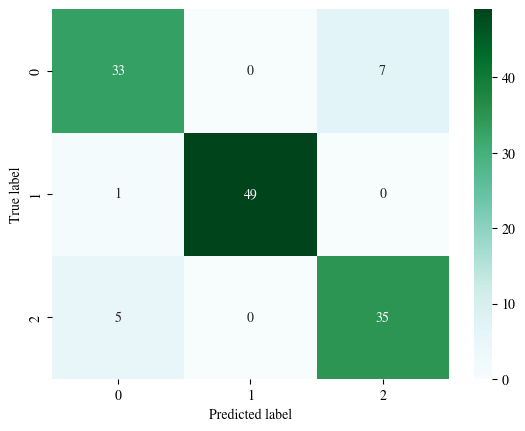

In [14]:
rfc_time = make_pipeline(rfc_grid_search.best_estimator_)
rfc_time.fit(X_time_train, y_time_train)
y_time_pred = rfc_time.predict(X_time_test)
y_time_pred_prob = rfc_time.predict_proba(X_time_test)
rfc_time_result = confusion_matrix(y_time_test, y_time_pred)
print(rfc_time_result)
rfc_time_result1 = classification_report(y_time_test, y_time_pred)
print("Classification report: ")
print(rfc_time_result1)
rfc_time_acc = accuracy_score(y_time_test,y_time_pred)
print("Accuracy: ", rfc_time_acc)

confusion_matrix_plot(rfc_time_result, "Random Forest", 0)


In [15]:
# Hyper parameter tuning for knn - COMMENT OUT IF YOU DON'T WANT TO RUN (TAKES A LONG TIME)

n_neighbors = list(range(1,5))
p = [1,2]
#Convert to dictionary
hyperparameters = dict( n_neighbors=n_neighbors, p=p)

#Create new KNN object
knn_2 = KNeighborsClassifier()#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, verbose=3, cv=tscv)

#Fit the model
knn_grid_search = clf.fit(X_time_train,y_time_train)

print('Best p:', knn_grid_search.best_estimator_.get_params()['p'])
print('Best n_neighbors:', knn_grid_search.best_estimator_.get_params()['n_neighbors'])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................n_neighbors=1, p=1;, score=0.814 total time=   0.1s
[CV 2/5] END ................n_neighbors=1, p=1;, score=0.570 total time=   0.1s
[CV 3/5] END ................n_neighbors=1, p=1;, score=0.965 total time=   0.2s
[CV 4/5] END ................n_neighbors=1, p=1;, score=0.128 total time=   0.2s
[CV 5/5] END ................n_neighbors=1, p=1;, score=0.686 total time=   0.4s
[CV 1/5] END ................n_neighbors=1, p=2;, score=0.814 total time=   0.0s
[CV 2/5] END ................n_neighbors=1, p=2;, score=0.547 total time=   0.0s
[CV 3/5] END ................n_neighbors=1, p=2;, score=0.965 total time=   0.0s
[CV 4/5] END ................n_neighbors=1, p=2;, score=0.128 total time=   0.0s
[CV 5/5] END ................n_neighbors=1, p=2;, score=0.674 total time=   0.0s
[CV 1/5] END ................n_neighbors=2, p=1;, score=0.814 total time=   0.0s
[CV 2/5] END ................n_neighbors=2, p=1;,

In [16]:
knn_grid_search.best_params_

{'n_neighbors': 3, 'p': 2}

Confusion Matrix: 
[[38  0  2]
 [ 0 50  0]
 [ 5  0 35]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.88      0.95      0.92        40
         1.0       1.00      1.00      1.00        50
         2.0       0.95      0.88      0.91        40

    accuracy                           0.95       130
   macro avg       0.94      0.94      0.94       130
weighted avg       0.95      0.95      0.95       130

Accuracy:  0.9461538461538461


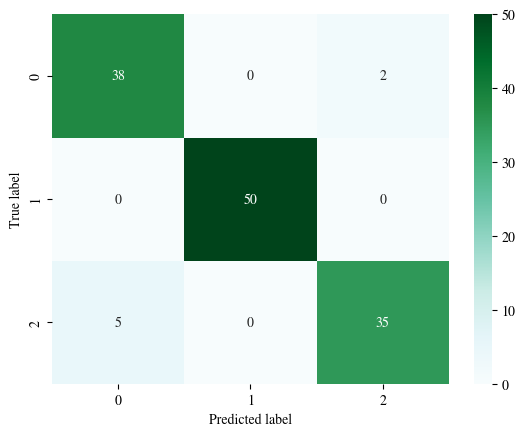

In [17]:
knn = make_pipeline(StandardScaler(),knn_grid_search.best_estimator_)
knn.fit(X_time_train, y_time_train)
y_time_pred = knn.predict(X_time_test)
y_time_pred_prob = knn.predict_proba(X_time_test)
knn_time_result = confusion_matrix(y_time_test, y_time_pred)
print("Confusion Matrix: ")
print(knn_time_result)
knn_class_report = classification_report(y_time_test, y_time_pred)
print("Classification report: ")
print(knn_class_report)
knn_acc = accuracy_score(y_time_test,y_time_pred)
print("Accuracy: ",knn_acc)

confusion_matrix_plot(knn_time_result, "KNN", 0)

In [18]:

svc_param_grid = { 
    # Regularization parameter.
    "C": [1, 2, 5],
    # Kernel type
    "kernel": ['rbf', 'poly'],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": [1, 2, 5],
    }

svc = SVC(random_state=1234)
svc_grid_search = GridSearchCV(estimator=svc, param_grid=svc_param_grid, cv=tscv, verbose=2)
svc_grid_search.fit(X_time_train, y_time_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   0.6s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   3.4s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   5.0s
[CV] END ...........................C=1, gamma=1, kernel=rbf; total time=   7.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.0s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   0.5s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   2.4s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   3.7s
[CV] END ..........................C=1, gamma=1, kernel=poly; total time=   5.8s
[CV] END ...........................C=1, gamma=2, kernel=rbf; total time=   0.0s
[CV] END ...........................C=1, gamma=2

C:\Users\Abdus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
18 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Abdus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Abdus\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=SVC(random_state=1234),
             param_grid={'C': [1, 2, 5], 'gamma': [1, 2, 5],
                         'kernel': ['rbf', 'poly']},
             verbose=2)

In [19]:
svc_grid_search.best_params_

{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

In [20]:
poly = SVC(C=svc_grid_search.best_params_['C'], gamma=svc_grid_search.best_params_['gamma'],kernel=svc_grid_search.best_params_['kernel'])
poly.fit(X_time_train, y_time_train)
poly_pred = poly.predict(X_time_test)

Classification report: 
              precision    recall  f1-score   support

         0.0       0.87      1.00      0.93        40
         1.0       0.93      1.00      0.96        50
         2.0       1.00      0.75      0.86        40

    accuracy                           0.92       130
   macro avg       0.93      0.92      0.92       130
weighted avg       0.93      0.92      0.92       130

Accuracy:  0.9230769230769231


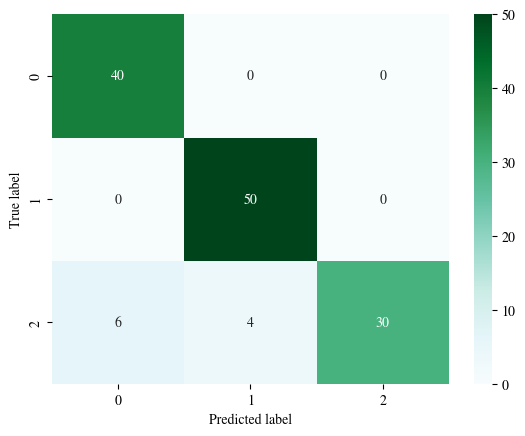

In [21]:
poly_result = confusion_matrix(y_time_test, poly_pred)
poly_classification_rep = classification_report(y_time_test, poly_pred)
print("Classification report: ")
print(poly_classification_rep)
poly_acc = accuracy_score(y_time_test,poly_pred)
print("Accuracy: ", poly_acc)
confusion_matrix_plot(poly_result, "SVM", 0)

Classification report: 
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80        33
         1.0       0.92      0.92      0.92        53
         2.0       0.95      0.86      0.90        44

    accuracy                           0.88       130
   macro avg       0.88      0.88      0.88       130
weighted avg       0.89      0.88      0.89       130



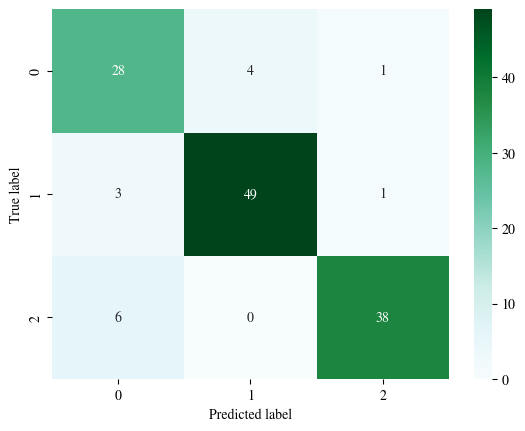

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_split, random_state=1234)

rfc_rand = make_pipeline(rfc_grid_search.best_estimator_)
rfc_rand.fit(X_train, y_train)
y_pred = rfc_rand.predict(X_test)
rfc_result = confusion_matrix(y_test, y_pred)
rfc_result1 = classification_report(y_test, y_pred)
print("Classification report: ")
print(rfc_result1)
rfc_acc = accuracy_score(y_test,y_pred)


confusion_matrix_plot(rfc_result, "Random Forest", 0)

Confusion Matrix: 
[[29  4  0]
 [ 0 53  0]
 [ 7  1 36]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84        33
         1.0       0.91      1.00      0.95        53
         2.0       1.00      0.82      0.90        44

    accuracy                           0.91       130
   macro avg       0.91      0.90      0.90       130
weighted avg       0.92      0.91      0.91       130

Accuracy:  0.9076923076923077


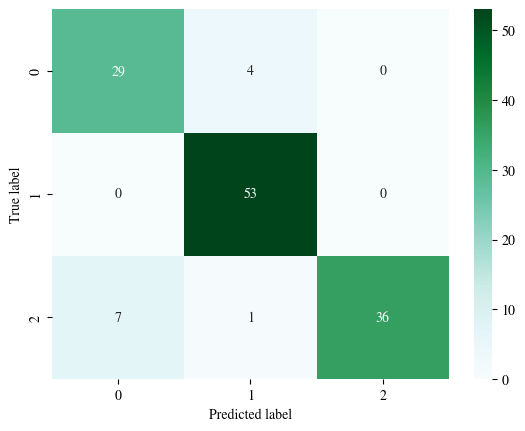

In [24]:
knn = make_pipeline(StandardScaler(),knn_grid_search.best_estimator_)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(knn_result)
knn_class_report = classification_report(y_test, y_pred)
print("Classification report: ")
print(knn_class_report)
knn_acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",knn_acc)

confusion_matrix_plot(knn_result, "KNN", 0)

In [25]:
poly = SVC(C=svc_grid_search.best_params_['C'], gamma=svc_grid_search.best_params_['gamma'],kernel=svc_grid_search.best_params_['kernel'])
poly.fit(X_train, y_train)
y_pred = poly.predict(X_test)
poly_result = confusion_matrix(y_test, y_pred)
print("Confusion Matrix: ")
print(poly_result)
poly_class_report = classification_report(y_test, y_pred)
print("Classification report: ")
print(poly_class_report)
poly_acc = accuracy_score(y_test,y_pred)
print("Accuracy: ",poly_acc)

Confusion Matrix: 
[[26  7  0]
 [ 0 52  1]
 [12  2 30]]
Classification report: 
              precision    recall  f1-score   support

         0.0       0.68      0.79      0.73        33
         1.0       0.85      0.98      0.91        53
         2.0       0.97      0.68      0.80        44

    accuracy                           0.83       130
   macro avg       0.83      0.82      0.81       130
weighted avg       0.85      0.83      0.83       130

Accuracy:  0.8307692307692308


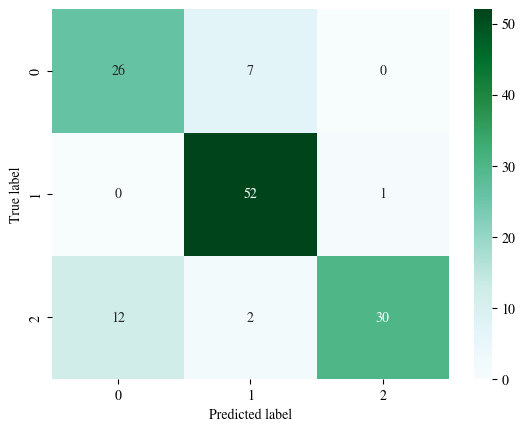

In [26]:
confusion_matrix_plot(poly_result, "SVM", 0)

In [9]:
from keras import models, layers, initializers, utils, callbacks, regularizers
import tensorflow as tf

In [10]:
train_labels = utils.to_categorical(y_time_train)
train_labels.shape

(520, 3)

In [67]:
model = models.Sequential(
    [
        layers.Input(shape=(X_time_train.shape[1],1)),
        layers.Conv1D(32, 10, strides=3, activation='relu'),
        layers.MaxPool1D(pool_size=3, strides=3),
        layers.Conv1D(16, 5, strides=2, activation='relu'),
        layers.MaxPool1D(pool_size=2, strides=2),
        #layers.SpatialDropout1D(0.6),
        layers.Flatten(),
        layers.Dense(256, activation='linear'),
        layers.Dense(64, activation='linear'),
        layers.Dropout(0.6),
        layers.Dense(3, activation="softmax")
    ]
)

model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 3331, 32)          352       
                                                                 
 max_pooling1d_38 (MaxPoolin  (None, 1110, 32)         0         
 g1D)                                                            
                                                                 
 conv1d_45 (Conv1D)          (None, 553, 16)           2576      
                                                                 
 max_pooling1d_39 (MaxPoolin  (None, 276, 16)          0         
 g1D)                                                            
                                                                 
 flatten_17 (Flatten)        (None, 4416)              0         
                                                                 
 dense_39 (Dense)            (None, 256)             

In [68]:
es = callbacks.EarlyStopping(monitor='val_accuracy', patience=7)
model.compile(loss="categorical_crossentropy", 
              optimizer="adam", 
              metrics=["accuracy"])

history = model.fit(X_time_train, train_labels,
                    batch_size=64, 
                    epochs=100, 
                    validation_split=0.1,
                    callbacks=[es])

Epoch 1/100
8/8 [==============================] - 5s 243ms/step - loss: 1.0883 - accuracy: 0.4017 - val_loss: 1.3338 - val_accuracy: 0.0769
Epoch 2/100
8/8 [==============================] - 1s 181ms/step - loss: 1.0286 - accuracy: 0.4658 - val_loss: 1.4771 - val_accuracy: 0.0962
Epoch 3/100
8/8 [==============================] - 2s 186ms/step - loss: 0.9419 - accuracy: 0.5064 - val_loss: 0.9339 - val_accuracy: 0.5962
Epoch 4/100
8/8 [==============================] - 2s 202ms/step - loss: 0.8043 - accuracy: 0.6667 - val_loss: 1.2052 - val_accuracy: 0.3654
Epoch 5/100
8/8 [==============================] - 2s 216ms/step - loss: 0.6590 - accuracy: 0.7543 - val_loss: 0.2485 - val_accuracy: 0.9038
Epoch 6/100
8/8 [==============================] - 2s 196ms/step - loss: 0.6261 - accuracy: 0.7457 - val_loss: 0.9262 - val_accuracy: 0.5769
Epoch 7/100
8/8 [==============================] - 1s 184ms/step - loss: 0.5433 - accuracy: 0.7906 - val_loss: 0.8154 - val_accuracy: 0.6346
Epoch 8/100
8

In [69]:
test_labels  = utils.to_categorical(y_time_test)

In [70]:
loss, acc = model.evaluate(X_time_test, test_labels, batch_size=64)
loss,acc

3/3 [==============================] - 0s 36ms/step - loss: 0.2778 - accuracy: 0.9308


(0.2778123617172241, 0.9307692050933838)

In [71]:
y_pred = np.argmax(model.predict(X_time_test), axis=1)

5/5 [==============================] - 0s 22ms/step


In [72]:
cnn_cm = confusion_matrix(y_time_test, y_pred)

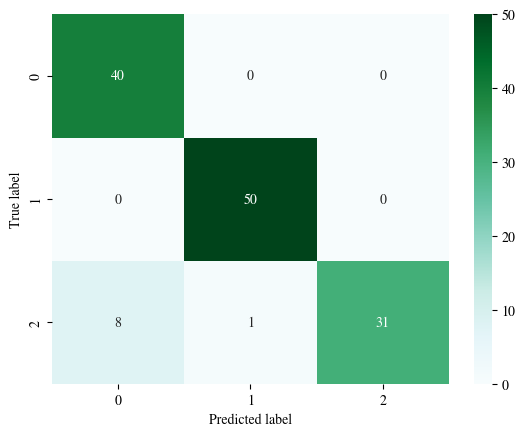

In [73]:
confusion_matrix_plot(cnn_cm, "CNN", 0)

In [74]:
cnn_class_report = classification_report(y_time_test, y_pred)
print(cnn_class_report)

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91        40
         1.0       0.98      1.00      0.99        50
         2.0       1.00      0.78      0.87        40

    accuracy                           0.93       130
   macro avg       0.94      0.92      0.92       130
weighted avg       0.94      0.93      0.93       130

